In [39]:
import pandas as pd
import json
import sys
sys.path.append("../")
import shared
shared.init()
import matplotlib.pyplot as plt

from features.pool_features import get_pool_features
from features.transfer_features import get_transfer_features, get_curve

In [40]:
def plot_time_series(address, eval_blocks):
    data_root_path = f"/media/victor/Elements/data" #Example
    
    pool_features = pd.read_csv("../data/pool_heuristics.csv", index_col="token_address")
    decimals = pd.read_csv(f'{data_root_path}/decimals.csv', index_col="token_address")
    with open('../data/pools_of_token.json', 'r') as f:
        pool_of_token = json.loads(f.read())

    pool_address = pool_features.loc[address]['pool_address']
    decimal = decimals.loc[address].iloc[0]
    pool = pool_of_token[address][0]

    weth_position = 0 if shared.WETH == pool['token0'] else 1

    with open(f'{data_root_path}/pool_sync_events/{pool_address}.json') as f:
        events = json.loads(f.read())
    f.close()

    token_position = 1 if weth_position == 0 else 0

    reserves = {}
    for event in events:
        reserves[event['blockNumber']] = {
            'WETH': event['args'][f'reserve{weth_position}'] / 10 ** 18,
            'token': event['args'][f'reserve{token_position}'] / 10 ** decimal
        }

    liquidity, blocks, prices, weth = [], [], [], []
    for block, info in reserves.items():
        blocks.append(block)
        liquidity.append(info['token'] * info['WETH'])
        prices.append(info['WETH'] / info['token'])
        weth.append(info['WETH'])

    plt.plot(blocks, liquidity, color='black', linewidth=1)
    plt.ylabel("Liquidity", fontdict={'family': 'sans-serif'})
    plt.xlabel("Block", fontdict={'family': 'sans-serif'})
    colors = ['red', 'peru', 'orange', 'darkblue', 'teal', 'grey']
    if eval_blocks:
        for i, block in enumerate(eval_blocks):
            plt.axvline(x=block, label='Evaluation block {}'.format(block), color=colors[i])
        plt.legend()
    plt.show()

    plt.plot(blocks, prices, color='black', linewidth=1)
    plt.ylabel("Price", fontdict={'family': 'sans-serif'})
    plt.xlabel("Block", fontdict={'family': 'sans-serif'})
    if eval_blocks:
        for i, block in enumerate(eval_blocks):
            plt.axvline(x=block, label='Evaluation block {}'.format(block), color=colors[i])
        plt.legend()
    plt.show()


## NON MALICIOUS TOKEN

In [41]:
token_address = "0x4Ddc2D193948926D02f9B1fE9e1daa0718270ED5"
pool_address = "0x7f438878071228319Bd321B170EE16fC92fd6D12"
eval_block = 11505214

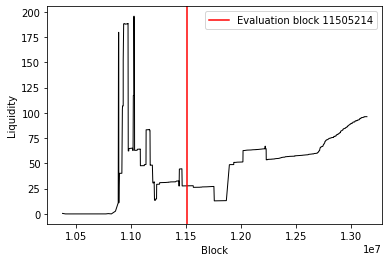

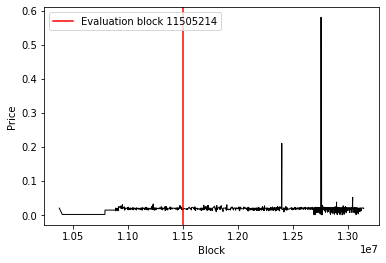

In [42]:
plot_time_series(token_address, [eval_block])

In [43]:
# READ DATA
data_root_path = f"/media/victor/Elements/data" #Example

transfers = pd.read_csv(f"{data_root_path}/Token_tx/{token_address}.csv")
with open(f'{data_root_path}/pool_lptransfers/{pool_address}.json', 'r') as f:
    lp_transfers = json.loads(f.read())

lp_transfers = pd.DataFrame([[info['transactionHash'], info['blockNumber']] + list(info['args'].values()) + [info['type']] for info in lp_transfers])
lp_transfers.columns = list(transfers.columns) + ['type']
with open(f'{data_root_path}/pool_sync_events/{pool_address}.json', 'r') as f:
    syncs = json.loads(f.read())
syncs = pd.DataFrame([[info['blockNumber']] + list(info['args'].values()) for info in syncs])
syncs.columns = ['blockNumber', 'reserve0', 'reserve1']

In [44]:
import pprint

# COMPUTE FEATURES
computed_features = {}
computed_features.update(get_transfer_features(transfers.loc[transfers.block_number < eval_block].values))
computed_features.update(get_curve(transfers.loc[transfers.block_number < eval_block].values))

computed_features.update({'liq_curve': get_curve(
    lp_transfers.loc[lp_transfers.block_number < eval_block].values)['tx_curve']})

transfer_types = lp_transfers.loc[lp_transfers.block_number < eval_block]['type'].value_counts()
computed_features.update({'Mint': 0, 'Burn': 0, 'Transfer': 0})
for type_ in transfer_types.index:
    computed_features[type_] = transfer_types[type_]
computed_features.update(
    {'difference_token_pool': lp_transfers['block_number'].iloc[0] - transfers['block_number'].iloc[0]}
)
computed_features.update(get_pool_features(syncs.loc[syncs.blockNumber < eval_block], position=1, decimal=18))
print("Total features")
pprint.pprint(computed_features)

Total features
{'Burn': 30,
 'Mint': 26,
 'Transfer': 0,
 'WETH': 0.7196348685040534,
 'cluster_coeff': 0.1332121838424255,
 'difference_token_pool': 2665061,
 'liq_curve': 0.2934934421898758,
 'liquidity': 2.7843229390549623e-09,
 'n_syncs': 440,
 'n_unique_addresses': 71343,
 'num_transactions': 184561,
 'prices': 185996508.05686358,
 'tx_curve': 2.507857741713236e+19}


In [45]:
import joblib
model = joblib.load("xgboost.joblib")
proba = model.predict_proba(pd.DataFrame(computed_features, index=[0]))[0, 1]
print("Probability of being non-malicious: ", proba)

Probability of being non-malicious:  0.9999385


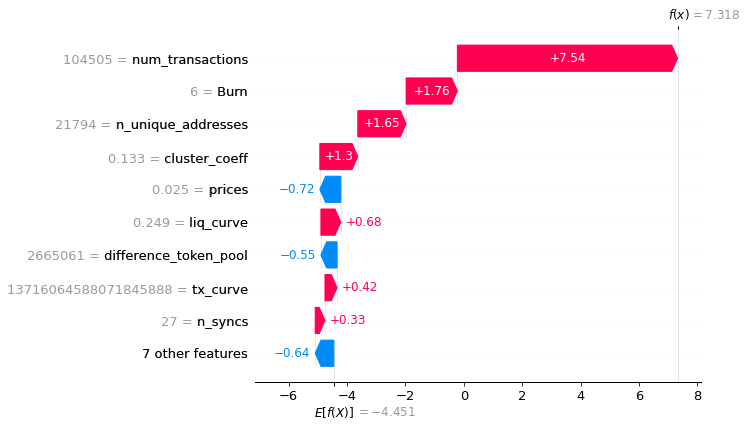

In [46]:
import shap
import numpy as np

X = pd.read_csv("X.csv", index_col="token_address").drop(["eval_block"], axis=1)
lock_features = pd.read_csv("../data/token_lock_features.csv", index_col="token_address")
X = X.merge(lock_features, how='left', left_index=True, right_index=True)
token_index = np.where(X.index == token_address)[0][0]
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[token_index])


## MALICIOUS TOKEN

In [47]:
token_address = "0xF4FB54c667FE525cf4811df291b2A2892261c3d7"
pool_address = "0x7786743AD0aece38f325A90Bc96AFb2e9cd30B5e"
eval_block = 11090150

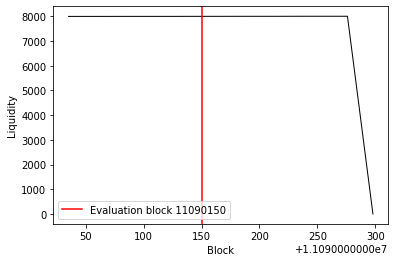

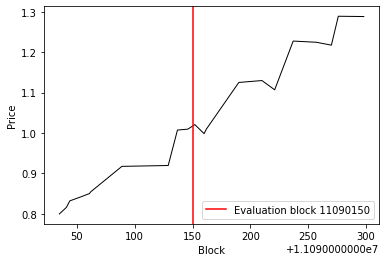

In [48]:
plot_time_series(token_address, [eval_block])

In [49]:
# READ DATA
transfers = pd.read_csv(f"{data_root_path}/Token_tx/{token_address}.csv")
with open(f'{data_root_path}/pool_lptransfers/{pool_address}.json', 'r') as f:
    lp_transfers = json.loads(f.read())

lp_transfers = pd.DataFrame([[info['transactionHash'], info['blockNumber']] + list(info['args'].values()) + [info['type']] for info in lp_transfers])
lp_transfers.columns = list(transfers.columns) + ['type']
with open(f'{data_root_path}/pool_sync_events/{pool_address}.json', 'r') as f:
    syncs = json.loads(f.read())
syncs = pd.DataFrame([[info['blockNumber']] + list(info['args'].values()) for info in syncs])
syncs.columns = ['blockNumber', 'reserve0', 'reserve1']

In [50]:
import pprint

# COMPUTE FEATURES
computed_features = {}
computed_features.update(get_transfer_features(transfers.loc[transfers.block_number < eval_block].values))
computed_features.update(get_curve(transfers.loc[transfers.block_number < eval_block].values))

computed_features.update({'liq_curve': get_curve(
    lp_transfers.loc[lp_transfers.block_number < eval_block].values)['tx_curve']})

transfer_types = lp_transfers.loc[lp_transfers.block_number < eval_block]['type'].value_counts()
computed_features.update({'Mint': 0, 'Burn': 0, 'Transfer': 0})
for type_ in transfer_types.index:
    computed_features[type_] = transfer_types[type_]
computed_features.update(
    {'difference_token_pool': lp_transfers['block_number'].iloc[0] - transfers['block_number'].iloc[0]}
)
computed_features.update(get_pool_features(syncs.loc[syncs.blockNumber < eval_block], position=1, decimal=18))
print("Total features")
pprint.pprint(computed_features)

Total features
{'Burn': 0,
 'Mint': 2,
 'Transfer': 0,
 'WETH': 89.03292971365505,
 'cluster_coeff': 0.0,
 'difference_token_pool': 22,
 'liq_curve': 1.0,
 'liquidity': 8002.754188759739,
 'n_syncs': 13,
 'n_unique_addresses': 15,
 'num_transactions': 14,
 'prices': 0.9905168128905305,
 'tx_curve': 0.8179578620603711}


In [51]:
import joblib
model = joblib.load("xgboost.joblib")
proba = model.predict_proba(pd.DataFrame(computed_features, index=[0]))[0, 1]
print("Probability of being non-malicious: ", proba)

Probability of being non-malicious:  3.973074e-06


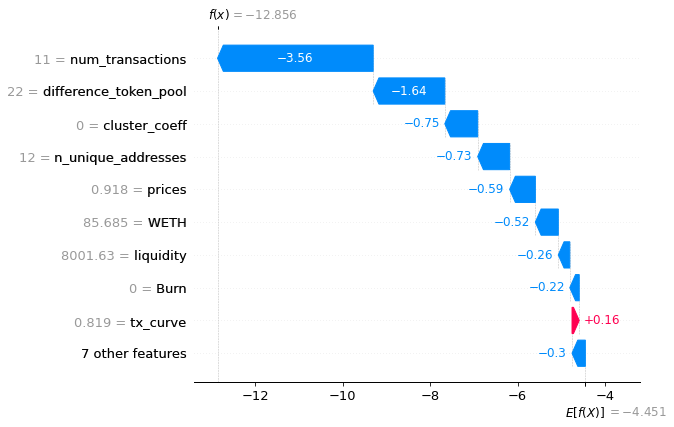

In [52]:
import shap
import numpy as np

X = pd.read_csv("X.csv", index_col="token_address").drop(["eval_block"], axis=1)
lock_features = pd.read_csv("../data/token_lock_features.csv", index_col="token_address")
X = X.merge(lock_features, how='left', left_index=True, right_index=True)
token_index = np.where(X.index == token_address)[0][0]
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[token_index])